# Transformer, Self-Attention и моделирование языка

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator
from dlnlputils.pipeline import train_eval_loop, init_random_seed
from dlnlputils.base import get_params_number

init_random_seed()

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
all_chunks = load_war_and_piece_chunks('./datasets/war_and_peace.txt')
len(all_chunks)

7976

In [3]:
print(all_chunks[10])

у нее был грипп, как она говорила (грипп был тогда новое
слово, употреблявшееся только редкими). В записочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez


In [4]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 5583
Размер валидационной выборки 2393


## Токенизация корпуса с помощью BPE

BPE - Byte Pair Encoding

YouTokenToMe - быстрая реализация BPE

In [5]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
BPE_MODEL_FILENAME = './models/war_and_peace_bpe.yttm'

In [6]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
TRAIN_TEXTS_FILENAME = './datasets/war_and_peace_bpe_train.txt'
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);

In [7]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [8]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

In [9]:
print(tokenizer.encode(train_texts[:1]))

[[210, 238, 244, 13, 317, 16, 147, 200, 12, 265, 35, 161, 337, 490, 203, 269, 447, 4, 111, 111, 96, 27, 415, 148, 176, 551, 201, 726, 199, 161, 848, 889, 772, 23, 16, 690, 179, 585, 18, 154, 412, 19, 382, 157, 186, 635, 10, 518, 774, 363, 670, 157, 793, 37, 7, 426, 791, 186, 635, 10, 518, 774, 650, 25, 988, 206, 186, 13, 201, 8, 149, 474, 17, 275, 31, 23, 8, 34, 444]]


In [10]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

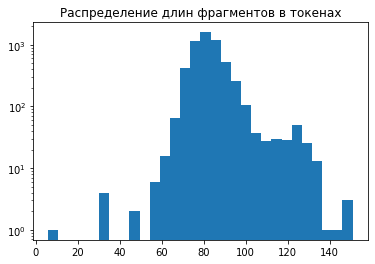

In [11]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

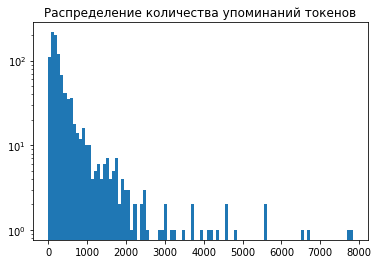

In [12]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [13]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


## Подготовка датасетов для PyTorch

In [14]:
from torch.utils.data import Dataset
from dlnlputils.data.nnets import ensure_length
import random

CHUNK_LENGTH = 80

class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=100, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1)) 
        chunk = text[start_i : start_i + self.chunk_length + 1] #получение случайного фрагмента

        seed_part = chunk[:-1] #  a b c - смещённые влево токены для обучения [:i+1] для предсказания i
        target_part = chunk[1:] # b c d - токены для предсказания

        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part

train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

In [15]:
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444]),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3]))

In [16]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Общие классы и функции

### Маска зависимостей

для закрытия токенов справа

In [17]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Кодирование позиции

In [18]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

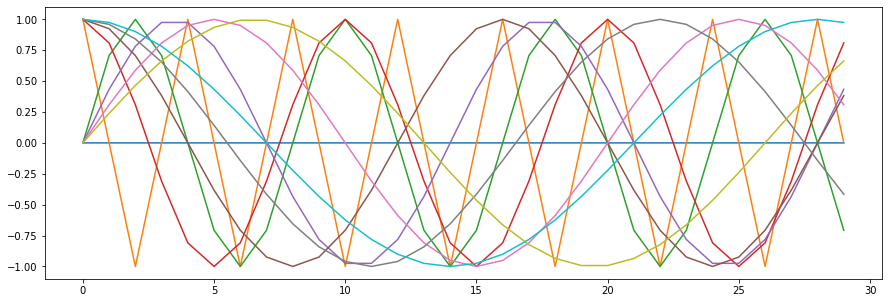

In [19]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:, ::3].numpy());
plt.gcf().set_size_inches((15, 5))

### Основной класс - языковая модель

In [20]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)
        
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = seed_embs
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

In [21]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

## Реализация Transformer из PyTorch 1.2

In [22]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize - вход трансформера
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [23]:
backbone = BatchFirstTransformerEncoder(
   nn.TransformerEncoderLayer(
       d_model=256,
       nhead=16,
       dim_feedforward=512,
       dropout=0.1
   ),
   num_layers=3
)

torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   backbone,
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [34]:
(best_val_loss,
 best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                            train_dataset,
                                            test_dataset,
                                            lm_cross_entropy,
                                            lr=2e-3,
                                            epoch_n=2000,
                                            batch_size=512,
                                            device='cuda',
                                            early_stopping_patience=50,
                                            max_batches_per_epoch_train=1000,
                                            max_batches_per_epoch_val=1000,
                                            lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 6.403912847692316
Среднее значение функции потерь на валидации 6.245821762084961
Новая лучшая модель!

Эпоха 1
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 6.243868871168657
Среднее значение функции потерь на валидации 6.246075630187988

Эпоха 2
Эпоха: 11 итераций, 1.06 сек
Среднее значение функции потерь на обучении 6.220285285602916
Среднее значение функции потерь на валидации 6.21402063369751
Новая лучшая модель!

Эпоха 3
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 6.136191151358864
Среднее значение функции потерь на валидации 5.953598976135254
Новая лучшая модель!

Эпоха 4
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 5.798463908108798
Среднее значение функции потерь на валидации 5.505068397521972
Новая лучшая модель!

Эпоха 5
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 5.331767429005016
Сре

Эпоха: 11 итераций, 1.06 сек
Среднее значение функции потерь на обучении 2.7122278213500977
Среднее значение функции потерь на валидации 3.2016953945159914
Новая лучшая модель!

Эпоха 46
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 2.6992088014429267
Среднее значение функции потерь на валидации 3.1929750442504883
Новая лучшая модель!

Эпоха 47
Эпоха: 11 итераций, 1.05 сек
Среднее значение функции потерь на обучении 2.6828914122147993
Среднее значение функции потерь на валидации 3.1831719875335693
Новая лучшая модель!

Эпоха 48
Эпоха: 11 итераций, 1.04 сек
Среднее значение функции потерь на обучении 2.663166414607655
Среднее значение функции потерь на валидации 3.1810450553894043
Новая лучшая модель!

Эпоха 49
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 2.6447304595600474
Среднее значение функции потерь на валидации 3.1751780986785887
Новая лучшая модель!

Эпоха 50
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на об

Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 2.2058250687339087
Среднее значение функции потерь на валидации 3.005857515335083
Новая лучшая модель!

Эпоха 91
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 2.2011145895177666
Среднее значение функции потерь на валидации 3.007277011871338

Эпоха 92
Эпоха: 11 итераций, 1.14 сек
Среднее значение функции потерь на обучении 2.194939136505127
Среднее значение функции потерь на валидации 3.0075706958770754

Эпоха 93
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 2.1853598681363193
Среднее значение функции потерь на валидации 2.998022222518921
Новая лучшая модель!

Эпоха 94
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 2.1803429993716152
Среднее значение функции потерь на валидации 2.998463487625122

Эпоха 95
Эпоха: 11 итераций, 1.10 сек
Среднее значение функции потерь на обучении 2.1736818226900967
Среднее значение функции потерь на валида

Среднее значение функции потерь на валидации 2.901943397521973

Эпоха 137
Эпоха: 11 итераций, 1.16 сек
Среднее значение функции потерь на обучении 1.9745987003499812
Среднее значение функции потерь на валидации 2.9040003776550294

Эпоха 138
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.9666553193872625
Среднее значение функции потерь на валидации 2.8934619426727295
Новая лучшая модель!

Эпоха 139
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.9692730145020918
Среднее значение функции потерь на валидации 2.8967777252197267

Эпоха 140
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.9633025581186467
Среднее значение функции потерь на валидации 2.897968053817749

Эпоха 141
Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.9578138698231091
Среднее значение функции потерь на валидации 2.901295709609985

Эпоха 142
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении

Среднее значение функции потерь на валидации 2.8426512718200683

Эпоха 184
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 1.8409845178777522
Среднее значение функции потерь на валидации 2.8310538291931153
Новая лучшая модель!

Эпоха 185
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.83656767281619
Среднее значение функции потерь на валидации 2.8416810512542723

Эпоха 186
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.8332946408878674
Среднее значение функции потерь на валидации 2.830537033081055
Новая лучшая модель!

Эпоха 187
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.8315520720048384
Среднее значение функции потерь на валидации 2.834748458862305

Эпоха 188
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.8297786495902322
Среднее значение функции потерь на валидации 2.8276715755462645
Новая лучшая модель!

Эпоха 189
Эпоха: 11 итераций, 1.07 сек
Ср

Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.748565825549039
Среднее значение функции потерь на валидации 2.7898401260375976
Новая лучшая модель!

Эпоха 232
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.7417981841347434
Среднее значение функции потерь на валидации 2.7844831943511963
Новая лучшая модель!

Эпоха 233
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.7438822009346702
Среднее значение функции потерь на валидации 2.7952276706695556

Эпоха 234
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 1.7444599108262495
Среднее значение функции потерь на валидации 2.7884762287139893

Эпоха 235
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 1.740485505624251
Среднее значение функции потерь на валидации 2.793663167953491

Эпоха 236
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.7435618530620227
Среднее значение функции потерь на

Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.683481584895741
Среднее значение функции потерь на валидации 2.7636951923370363

Эпоха 280
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.6782477660612627
Среднее значение функции потерь на валидации 2.768339252471924

Эпоха 281
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.676467234438116
Среднее значение функции потерь на валидации 2.755790138244629
Новая лучшая модель!

Эпоха 282
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.6765667633576826
Среднее значение функции потерь на валидации 2.763127088546753

Эпоха 283
Эпоха: 11 итераций, 1.08 сек
Среднее значение функции потерь на обучении 1.6762462637641213
Среднее значение функции потерь на валидации 2.7529525756835938
Новая лучшая модель!

Эпоха 284
Эпоха: 11 итераций, 1.08 сек
Среднее значение функции потерь на обучении 1.6762683391571045
Среднее значение функции потерь на в

Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.6270532499660144
Среднее значение функции потерь на валидации 2.7399529457092284

Эпоха 328
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.6270271431316028
Среднее значение функции потерь на валидации 2.7365399837493896

Эпоха 329
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.6270126754587346
Среднее значение функции потерь на валидации 2.7379997253417967

Эпоха 330
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.626029448075728
Среднее значение функции потерь на валидации 2.732385540008545
Новая лучшая модель!

Эпоха 331
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.626411654732444
Среднее значение функции потерь на валидации 2.7356467247009277

Эпоха 332
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.624012524431402
Среднее значение функции потерь на валидации 2.737711954

Эпоха: 11 итераций, 1.08 сек
Среднее значение функции потерь на обучении 1.58878615769473
Среднее значение функции потерь на валидации 2.716665744781494

Эпоха 377
Эпоха: 11 итераций, 1.08 сек
Среднее значение функции потерь на обучении 1.5879090590910478
Среднее значение функции потерь на валидации 2.7234610080718995

Эпоха 378
Эпоха: 11 итераций, 1.15 сек
Среднее значение функции потерь на обучении 1.5838784629648381
Среднее значение функции потерь на валидации 2.714060592651367

Эпоха 379
Эпоха: 11 итераций, 1.08 сек
Среднее значение функции потерь на обучении 1.5875837802886963
Среднее значение функции потерь на валидации 2.720218324661255

Эпоха 380
Эпоха: 11 итераций, 1.08 сек
Среднее значение функции потерь на обучении 1.582190752029419
Среднее значение функции потерь на валидации 2.723065900802612

Эпоха 381
Эпоха: 11 итераций, 1.07 сек
Среднее значение функции потерь на обучении 1.5853654146194458
Среднее значение функции потерь на валидации 2.7263378620147707

Эпоха 382
Эпоха

Среднее значение функции потерь на валидации 2.682067060470581

Эпоха 424
Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.4560706507075916
Среднее значение функции потерь на валидации 2.6785128593444822

Эпоха 425
Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.4580163738944314
Среднее значение функции потерь на валидации 2.67647442817688
Новая лучшая модель!

Эпоха 426
Эпоха: 11 итераций, 1.04 сек
Среднее значение функции потерь на обучении 1.4598209316080266
Среднее значение функции потерь на валидации 2.6799483776092528

Эпоха 427
Эпоха: 11 итераций, 1.04 сек
Среднее значение функции потерь на обучении 1.4585179957476528
Среднее значение функции потерь на валидации 2.6760066032409666
Новая лучшая модель!

Эпоха 428
Эпоха: 11 итераций, 1.10 сек
Среднее значение функции потерь на обучении 1.4568646929480813
Среднее значение функции потерь на валидации 2.680836629867554

Эпоха 429
Эпоха: 11 итераций, 1.09 сек
Среднее значение функци

Эпоха: 11 итераций, 1.05 сек
Среднее значение функции потерь на обучении 1.4416839534586126
Среднее значение функции потерь на валидации 2.6722991466522217

Эпоха 473
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.4393364082683215
Среднее значение функции потерь на валидации 2.669271993637085

Эпоха 474
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.436460180716081
Среднее значение функции потерь на валидации 2.664888334274292

Эпоха 475
Эпоха: 11 итераций, 1.05 сек
Среднее значение функции потерь на обучении 1.4394801746715198
Среднее значение функции потерь на валидации 2.6627171516418455
Новая лучшая модель!

Эпоха 476
Эпоха: 11 итераций, 1.06 сек
Среднее значение функции потерь на обучении 1.4370222200046887
Среднее значение функции потерь на валидации 2.6652218818664553

Эпоха 477
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.4408271421085705
Среднее значение функции потерь на валидации 2.66959519

Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.3819714242761785
Среднее значение функции потерь на валидации 2.6519322395324707

Эпоха 521
Эпоха: 11 итераций, 1.10 сек
Среднее значение функции потерь на обучении 1.3819020011208274
Среднее значение функции потерь на валидации 2.647181177139282
Новая лучшая модель!

Эпоха 522
Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.37492666461251
Среднее значение функции потерь на валидации 2.654775285720825

Эпоха 523
Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.3796172033656726
Среднее значение функции потерь на валидации 2.6538368225097657

Эпоха 524
Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.3769143711436878
Среднее значение функции потерь на валидации 2.6490641593933106

Эпоха 525
Эпоха: 11 итераций, 1.11 сек
Среднее значение функции потерь на обучении 1.375430323860862
Среднее значение функции потерь на валидации 2.6480909347

Эпоха: 11 итераций, 1.04 сек
Среднее значение функции потерь на обучении 1.361227360638705
Среднее значение функции потерь на валидации 2.646469831466675

Эпоха 570
Эпоха: 11 итераций, 1.12 сек
Среднее значение функции потерь на обучении 1.3672900741750544
Среднее значение функции потерь на валидации 2.648124647140503

Эпоха 571
Эпоха: 11 итераций, 1.06 сек
Среднее значение функции потерь на обучении 1.3659166856245561
Среднее значение функции потерь на валидации 2.645642900466919

Эпоха 572
Эпоха: 11 итераций, 1.09 сек
Среднее значение функции потерь на обучении 1.3614598946137861
Среднее значение функции потерь на валидации 2.6476717948913575

Эпоха 573
Эпоха: 11 итераций, 1.04 сек
Среднее значение функции потерь на обучении 1.3661649118770252
Среднее значение функции потерь на валидации 2.6470369338989257

Эпоха 574
Эпоха: 11 итераций, 1.10 сек
Среднее значение функции потерь на обучении 1.36239463632757
Среднее значение функции потерь на валидации 2.6409104824066163
Новая лучшая мо

Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3320561539043079
Среднее значение функции потерь на валидации 2.6350778579711913

Эпоха 619
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3370359052311291
Среднее значение функции потерь на валидации 2.6369941234588623

Эпоха 620
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3363142555410212
Среднее значение функции потерь на валидации 2.6356085300445558

Эпоха 621
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3319106860594316
Среднее значение функции потерь на валидации 2.6307700634002686
Новая лучшая модель!

Эпоха 622
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3285158764232288
Среднее значение функции потерь на валидации 2.635109567642212

Эпоха 623
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3336113799702038
Среднее значение функции потерь на валидации 2.632005

Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3177752819928257
Среднее значение функции потерь на валидации 2.628861331939697

Эпоха 668
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.317943518812006
Среднее значение функции потерь на валидации 2.630759048461914

Эпоха 669
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.318944584239613
Среднее значение функции потерь на валидации 2.634844446182251

Эпоха 670
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3190129778601907
Среднее значение функции потерь на валидации 2.630048942565918

Эпоха 671
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3133676268837668
Среднее значение функции потерь на валидации 2.6312267780303955

Эпоха 672
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3170863389968872
Среднее значение функции потерь на валидации 2.6307212829589846

Эпоха 673
Эпох

Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3113858483054421
Среднее значение функции потерь на валидации 2.629637432098389

Эпоха 717
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3082594654776833
Среднее значение функции потерь на валидации 2.6274465560913085

Эпоха 718
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3064903996207498
Среднее значение функции потерь на валидации 2.6278244495391845

Эпоха 719
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3068742968819358
Среднее значение функции потерь на валидации 2.628346300125122

Эпоха 720
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3051101186058738
Среднее значение функции потерь на валидации 2.627645254135132

Эпоха 721
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3061676567251033
Среднее значение функции потерь на валидации 2.6315395832061768

Эпоха 722
Э

Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3021492849696765
Среднее значение функции потерь на валидации 2.628367567062378

Эпоха 766
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.306509787386114
Среднее значение функции потерь на валидации 2.6266972064971923

Эпоха 767
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3077980279922485
Среднее значение функции потерь на валидации 2.630731964111328

Эпоха 768
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.305869915268638
Среднее значение функции потерь на валидации 2.6276867389678955

Эпоха 769
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3056253303181042
Среднее значение функции потерь на валидации 2.6268524169921874
Epoch   770: reducing learning rate of group 0 to 7.8125e-06.

Эпоха 770
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3035676587711682
Среднее значени

Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3047663081776013
Среднее значение функции потерь на валидации 2.6295127868652344

Эпоха 815
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3043163472955877
Среднее значение функции потерь на валидации 2.6257352352142336

Эпоха 816
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3057116161693225
Среднее значение функции потерь на валидации 2.62990403175354

Эпоха 817
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.3028400594537908
Среднее значение функции потерь на валидации 2.625237989425659

Эпоха 818
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.305340517650951
Среднее значение функции потерь на валидации 2.623894214630127

Эпоха 819
Эпоха: 11 итераций, 1.03 сек
Среднее значение функции потерь на обучении 1.304773666641929
Среднее значение функции потерь на валидации 2.6310188293457033
Epoch   820: re

In [35]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(best_torch_transf_model.state_dict(), './models/war_and_peace_torch_transf_best.pth')

In [24]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch_transf_model.load_state_dict(torch.load('./models/war_and_peace_torch_transf_best.pth'))

<All keys matched successfully>

## Генерация текста с помощью языковой модели

### Жадная генерация

In [25]:
class GreedyGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40):
        seed_tokens = self.tokenizer.encode([seed_text])[0]

        for _ in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
            best_next_token = self.model(in_batch)[0, -1].argmax()
            if best_next_token == self.eos_token_id:
                break

            seed_tokens.append(best_next_token)

        return self.tokenizer.decode([seed_tokens])[0]

greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

In [26]:
%%time

print(greedy_generator('сказала княжна, оглядывая Бона'))

сказала княжна, оглядывая Бонапартаясь, подошел к окну, в державший ружеской ноги, и, как запчивая руками руку, шагов, сделал над
CPU times: user 971 ms, sys: 0 ns, total: 971 ms
Wall time: 96.2 ms


In [27]:
print(greedy_generator('смеялась княжна, оглядывая Наполе'))

смеялась княжна, оглядывая Наполеон, выхотно хотительно глядел на сапоми и шел красивое лицо, Несвицкий. Сам блестям вышел зац


In [28]:
print(greedy_generator('сказала княжна, оглядывая Кутуз'))

сказала княжна, оглядывая Кутузничивая рысью тоже в почти крупными глазаху. - "Наковай! Вот что это удовольло? - спросила она


In [29]:
print(greedy_generator('сказал Кутузов, оглядывая Наполеона'))

сказал Кутузов, оглядывая Наполеона и просторит. - Самялись, - проговорил он и еще с умел посторонем. Он не удивленно. - Я вот


### Генерация с помощью лучевого поиска - Beam Search

In [32]:
import heapq

class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []

        while len(partial_hypotheses) > 0:
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)

            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            topk_continuations = next_tokens_logproba.topk(beamsize)

            for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                token_score = float(token_score)
                token_idx = int(token_idx)

                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)

                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)

            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)

        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result


beam_generator = BeamGenerator(torch_transf_model, tokenizer)

In [33]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.9073862901171754
сказала княжна, оглядывая Наполеон. - Mon cher Borieкого человека и с удовольствием оглядываясь на Шварта. - То! - кричал

****
2.9470633016951937
сказала княжна, оглядывая Наполеон. - Mon cher Borieкого человека и с удовольствием оглядываясь на Шиншин и робовал князь Васили

****
2.9841124361951357
сказала княжна, оглядывая Наполеон. - Mon cher Borieкого человека и с удовольствием оглядываясь на Шварта. - То! - крик

****
3.2306363909233387
сказала княжна, оглядывая Наполеон. - Mon cher Bacrisile, avel envoient La Roi de Prusse! T

****
3.5788168261696742
сказала княжна, оглядывая Наполеон. - Mon cher Bacrisile, avel envoient La Prussienne, vous n'en

CPU times: user 3.3 s, sys: 14.6 ms, total: 3.32 s
Wall time: 288 ms


In [34]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=20,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
3.0938048683476
сказала княжна, оглядывая Наполеона и христиа и строго. Из XV. В этот Итвой фель Багратионув, который обеими руками с утром,

****
3.279251785726917
сказала княжна, оглядывая Наполеона. (Вол Charhereumeut vous. 556 XXVIII. Князь Багратион, усевшись в каби

****
3.293365584448825
сказала княжна, оглядывая Наполео, - сказал князь Андрей, видимо, не желая выехать. Разус! Княжна Марья не выступая вниз, как в

****
3.383615002057469
сказала княжна, оглядывая Наполео, - сказал князь Андрей, видимо, не желая выехать. Разус! Княжна Марья не выступая вниз, как чу

****
3.3847980809539093
сказала княжна, оглядывая Наполео, - сказал князь Андрей, видимо, не желая выехать. Разус! Княжна Марья не выступая вниз, как из

****
3.448163893110186
сказала княжна, оглядывая Наполео, - сказал князь Андрей, видимо, не желая выехать. Разус! Княжна Марья не выступила; пута. - 

****
3.473137066213252
сказала княжна, оглядывая Наполео, - сказал князь Андрей, видимо, не желая выехать. Разус

In [35]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=100,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
2.5880108867818703
сказала княжна, оглядывая Наполеона. (сноска 519) [Волконник,] (сноска 51) [Он всей] (сноска 5) [Василий,] (сноска 62

****
2.616767499947689
сказала княжна, оглядывая Наполеона. (сноска 94) [башно,] (сноска 40) Андрей,] (сноска 51) [Очаровательно,] (сноска 61) [Н

****
2.720870208412516
сказала княжна, оглядывая Наполеона. (сноска 519) [Волконник,] (сноска 51) [Видно, мой друг,] (сноска 6) [Да,] (сноска 6

****
2.721484712842479
сказала княжна, оглядывая Наполеона. (сноска 94) [башно,] (сноска 40) Андрей,] (сноска 52) [Посториезжай,] (сноска 62) [

****
2.7251209194096453
сказала княжна, оглядывая Наполеона. (сноска 94) [башно,] (сноска 40) Андрей,] (сноска 52) [Посториезжай,] (сноска 61) [

****
2.731796945082962
сказала княжна, оглядывая Наполеона. (сноска 519) [Волконник,] (сноска 57) [бая] (сноска 6) [Но, мой милый Пьер,] (сноска 

****
2.754896060349081
сказала княжна, оглядывая Наполеона. (сноска 94) [башно,] (сноска 40) Андрей,] (сноска 51) [Очаровательн

## Собственная реализация MultiHeadAttention

In [24]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x ValuesLen x HeadN x KeySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x KeysLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - ValuesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x ValuesLen x KeysLen x HeadN - attention map
    """

    # BatchSize x ValuesLen x KeysLen x HeadN
    relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))
    
    # замаскировать элементы, выходящие за длины последовательностей ключей
    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция>
    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    return result, normed_rels

## Self-Attention - это Attention, в котором ключи, значения и запросы вычисляются из элементов одной и той же последовательности

In [25]:
class MyMultiheadSelfAttention(nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads

        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None
    
    def forward(self, sequence, padding_mask, dependency_mask):
        """
        sequence - BatchSize x Len x ModelSize
        padding_mask - BatchSize x Len
        dependency_mask - Len x Len
        
        result - BatchSize x Len x ModelSize
        """
        batch_size, max_len, model_size = sequence.shape
        
        queries_flat = self.queries_proj(sequence)  # BatchSize x Len x ModelSize
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1)
        
        keys_flat = self.keys_proj(sequence)  # BatchSize x Len x ModelSize
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)
        
        values_flat = self.values_proj(sequence)  # BatchSize x Len x ModelSize
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)
        
        # BatchSize x Len x HeadsN x ValueSize
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        
        self.last_attention_map = att_map.detach()

        return result_flat

## Один слой трансформера - Self-Attention, Feed-Forward, skip-connections, LayerNorm

In [26]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size,
                                                       n_heads,
                                                       dropout=dropout)
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        return sequence

## Энкодер Трансформера - стопка из нескольких слоёв

In [27]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Попробуем обучить языковую модель с нашим Трансформером

In [28]:
my_transf_model = LanguageModel(tokenizer.vocab_size(),
                                256,
                                MyTransformerEncoder(
                                    n_layers=3,
                                    model_size=256,
                                    n_heads=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                emb_dropout=0.1)
print('Количество параметров', get_params_number(my_transf_model))

Количество параметров 1896936


In [31]:
(best_val_loss,
 best_my_transf_model) = train_eval_loop(my_transf_model,
                                         train_dataset,
                                         test_dataset,
                                         lm_cross_entropy,
                                         lr=2e-3,
                                         epoch_n=2000,
                                         batch_size=128,
                                         device='cuda',
                                         early_stopping_patience=50,
                                         max_batches_per_epoch_train=1000,
                                         max_batches_per_epoch_val=1000,
                                         lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 44 итераций, 2.73 сек
Среднее значение функции потерь на обучении 6.273215033791282
Среднее значение функции потерь на валидации 6.221561657754998
Новая лучшая модель!

Эпоха 1
Эпоха: 44 итераций, 2.70 сек
Среднее значение функции потерь на обучении 6.042017557404258
Среднее значение функции потерь на валидации 5.769685092725251
Новая лучшая модель!

Эпоха 2
Эпоха: 44 итераций, 2.77 сек
Среднее значение функции потерь на обучении 5.630281448364258
Среднее значение функции потерь на валидации 5.30332444843493
Новая лучшая модель!

Эпоха 3
Эпоха: 44 итераций, 2.84 сек
Среднее значение функции потерь на обучении 5.19611808386716
Среднее значение функции потерь на валидации 4.845356213419061
Новая лучшая модель!

Эпоха 4
Эпоха: 44 итераций, 2.68 сек
Среднее значение функции потерь на обучении 4.815383802760731
Среднее значение функции потерь на валидации 4.571245268771523
Новая лучшая модель!

Эпоха 5
Эпоха: 44 итераций, 2.80 сек
Среднее значение функции потерь на обучении 4

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(best_my_transf_model.state_dict(), './models/war_and_peace_my_transf_best.pth')

In [32]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
my_transf_model.load_state_dict(torch.load('./models/war_and_peace_my_transf_best.pth'))

FileNotFoundError: [Errno 2] No such file or directory: './models/war_and_peace_my_transf_best.pth'

## Наша реализация - жадная генерация

In [ ]:
my_greedy_generator = GreedyGenerator(my_transf_model, tokenizer)

In [ ]:
my_greedy_generator('сказала княжна, оглядывая Андре')

## Визуализация карт внимания

In [ ]:
def plot_attention_maps(model, input_string, tokenizer, device='cuda', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MyMultiheadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

In [ ]:
plot_attention_maps(my_transf_model, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)